In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_classification

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from config import AWS
from sqlalchemy import create_engine
import psycopg2 
import io

import warnings
warnings.filterwarnings('ignore')

In [2]:
# pull from database table with education data 

engine = create_engine(AWS)

employment_county_df = pd.read_sql('employ_county_edu', engine)

In [3]:
# employment_county_df  = pd.read_csv('../data_files/Employment_by_County_with_education_info.csv', index_col=0)
# employment_county_df.head(5)

In [4]:
employment_county_df

,index,geoid,county,labor_force,employed,unemployed,unemployed%_county,population,race_white,race_black,...,race_asian,race_islander,race_other,race_two_or_more,state,unemployement%_state,% completed_college_county,%not_completed_college_county,completed_college_county,Not_completed_college_county
0,0,1001,"Autauga County, Alabama",25838,24576,1262,4.9,58805,42160,11445,...,881,35,910,3157,Alabama,5.88,0.27,0.34,15625.41,19751.69
1,1,1003,"Baldwin County, Alabama",96763,91338,5425,5.6,231767,189399,18217,...,2067,143,5335,15024,Alabama,5.88,0.32,0.28,73846.67,64105.86
2,2,1005,"Barbour County, Alabama",8587,7982,605,7.0,25223,11317,11933,...,117,1,1039,700,Alabama,5.88,0.12,0.36,2920.50,8980.53
3,3,1007,"Bibb County, Alabama",8640,8067,573,6.6,22293,16555,4413,...,32,9,465,759,Alabama,5.88,0.10,0.45,2313.68,10004.82
4,4,1009,"Blount County, Alabama",24661,23653,1008,4.1,59134,50663,845,...,178,24,3431,3656,Alabama,5.88,0.13,0.33,7742.66,19763.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3120,3120,56037,"Sweetwater County, Wyoming",20840,19308,1532,7.4,42272,34389,366,...,295,70,2508,4211,Wyoming,5.84,0.23,0.33,9510.52,13967.21
3121,3121,56039,"Teton County, Wyoming",15204,14292,912,6.0,23331,19202,55,...,317,5,1415,2152,Wyoming,5.84,0.57,0.15,13299.87,3470.76
3122,3122,56041,"Uinta County, Wyoming",9312,8730,582,6.3,20450,18007,66,...,114,27,864,1181,Wyoming,5.84,0.16,0.42,3277.93,8491.39
3123,3123,56043,"Washakie County, Wyoming",4004,3793,211,5.3,7685,6600,12,...,33,3,388,572,Wyoming,5.84,0.23,0.30,1797.23,2286.38


In [5]:
employment_county_df = employment_county_df.drop(['index'],axis=1)

In [6]:
employment_county_df.isnull().values.any()

False

# Copy of the dataframe to feed ML 



In [7]:
employment_county_copy = employment_county_df.copy()

In [8]:
employment_county_copy.columns.to_list()

['geoid',
 'county',
 'labor_force',
 'employed',
 'unemployed',
 'unemployed%_county',
 'population',
 'race_white',
 'race_black',
 'race_native',
 'race_asian',
 'race_islander',
 'race_other',
 'race_two_or_more',
 'state',
 'unemployement%_state',
 '% completed_college_county',
 '%not_completed_college_county',
 'completed_college_county',
 'Not_completed_college_county']

In [9]:
employment_county_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3125 entries, 0 to 3124
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   geoid                          3125 non-null   int64  
 1   county                         3125 non-null   object 
 2   labor_force                    3125 non-null   int64  
 3   employed                       3125 non-null   int64  
 4   unemployed                     3125 non-null   int64  
 5   unemployed%_county             3125 non-null   float64
 6   population                     3125 non-null   int64  
 7   race_white                     3125 non-null   int64  
 8   race_black                     3125 non-null   int64  
 9   race_native                    3125 non-null   int64  
 10  race_asian                     3125 non-null   int64  
 11  race_islander                  3125 non-null   int64  
 12  race_other                     3125 non-null   i

In [10]:
# to increase model performance merging some of the race columns 
employment_county_copy['race_others']= employment_county_copy[['race_native','race_islander','race_other','race_two_or_more']].sum(axis=1)
employment_county_copy.head(5)

,geoid,county,labor_force,employed,unemployed,unemployed%_county,population,race_white,race_black,race_native,...,race_islander,race_other,race_two_or_more,state,unemployement%_state,% completed_college_county,%not_completed_college_county,completed_college_county,Not_completed_college_county,race_others
0,1001,"Autauga County, Alabama",25838,24576,1262,4.9,58805,42160,11445,217,...,35,910,3157,Alabama,5.88,0.27,0.34,15625.41,19751.69,4319
1,1003,"Baldwin County, Alabama",96763,91338,5425,5.6,231767,189399,18217,1582,...,143,5335,15024,Alabama,5.88,0.32,0.28,73846.67,64105.86,22084
2,1005,"Barbour County, Alabama",8587,7982,605,7.0,25223,11317,11933,116,...,1,1039,700,Alabama,5.88,0.12,0.36,2920.50,8980.53,1856
3,1007,"Bibb County, Alabama",8640,8067,573,6.6,22293,16555,4413,60,...,9,465,759,Alabama,5.88,0.10,0.45,2313.68,10004.82,1293
4,1009,"Blount County, Alabama",24661,23653,1008,4.1,59134,50663,845,337,...,24,3431,3656,Alabama,5.88,0.13,0.33,7742.66,19763.84,7448


In [11]:
# reducing columns to improve model performance 
# employment_county_copy = employment_county_copy.drop(['race_native','race_islander','race_other','race_two_or_more'],axis=1)

In [12]:
employment_county_copy.isnull().values.any()

False

In [13]:
employment_county_copy.shape

(3125, 21)

In [14]:
employment_county_copy.columns.to_list()

['geoid',
 'county',
 'labor_force',
 'employed',
 'unemployed',
 'unemployed%_county',
 'population',
 'race_white',
 'race_black',
 'race_native',
 'race_asian',
 'race_islander',
 'race_other',
 'race_two_or_more',
 'state',
 'unemployement%_state',
 '% completed_college_county',
 '%not_completed_college_county',
 'completed_college_county',
 'Not_completed_college_county',
 'race_others']

In [15]:
employment_county_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3125 entries, 0 to 3124
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   geoid                          3125 non-null   int64  
 1   county                         3125 non-null   object 
 2   labor_force                    3125 non-null   int64  
 3   employed                       3125 non-null   int64  
 4   unemployed                     3125 non-null   int64  
 5   unemployed%_county             3125 non-null   float64
 6   population                     3125 non-null   int64  
 7   race_white                     3125 non-null   int64  
 8   race_black                     3125 non-null   int64  
 9   race_native                    3125 non-null   int64  
 10  race_asian                     3125 non-null   int64  
 11  race_islander                  3125 non-null   int64  
 12  race_other                     3125 non-null   i

In [16]:
employment_county_copy = employment_county_copy.drop(['county','state'],axis=1)

In [17]:
employment_county_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3125 entries, 0 to 3124
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   geoid                          3125 non-null   int64  
 1   labor_force                    3125 non-null   int64  
 2   employed                       3125 non-null   int64  
 3   unemployed                     3125 non-null   int64  
 4   unemployed%_county             3125 non-null   float64
 5   population                     3125 non-null   int64  
 6   race_white                     3125 non-null   int64  
 7   race_black                     3125 non-null   int64  
 8   race_native                    3125 non-null   int64  
 9   race_asian                     3125 non-null   int64  
 10  race_islander                  3125 non-null   int64  
 11  race_other                     3125 non-null   int64  
 12  race_two_or_more               3125 non-null   i

# Targeting "unemployed" but we can target any of the employment columns


In [18]:
# trying to drop some heavily weighing features to see how it affects model accuracy

# for true prediction our X should not have anything related to employment need so add education to the X 

# 'labor_force',

X = employment_county_copy[['race_white', 'race_black', 'race_asian','race_others','completed_college_county','Not_completed_college_county']]



y = employment_county_copy['unemployed']


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, random_state=0)

In [20]:
# from sklearn.model_selection import GridSearchCV
# random_forest_tuning = RandomForestRegressor(random_state=0)
# param_grid = {
#     'n_estimators': [10, 20, 30],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth' : [4,5,6,7,8,9,10],
#     'criterion' :['squared_error', 'absolute_error'],
#     'min_samples_split': [2, 3, 4]
# }
# GSCV = GridSearchCV(estimator=random_forest_tuning, param_grid=param_grid, cv=5)
# GSCV.fit(X_train, y_train)
# print(GSCV.best_params_)

In [21]:
regressor = RandomForestRegressor(n_estimators=20,random_state=0,max_depth= 7,min_samples_split= 3,criterion='absolute_error')
regressor.fit(X_train,y_train)

RandomForestRegressor(criterion='absolute_error', max_depth=7,
                      min_samples_split=3, n_estimators=20, random_state=0)

In [22]:
y_pred = regressor.predict(X_test)

In [23]:
from sklearn.metrics import r2_score
r2_score(y_test,y_pred)

0.9363010344864999

In [24]:
regressor.score(X_train,y_train)

0.9740724789869264

In [25]:
regressor.score(X_test,y_test)

0.9363010344864999

In [26]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
mae

645.56236

In [27]:
min_unemployed = employment_county_df['unemployed'].min()
max_unemployed = employment_county_df['unemployed'].max()
print ('min = ', min_unemployed)
print('max = ', max_unemployed)

min =  4
max =  629811


In [28]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
mse

8249218.804411

In [29]:
from math import sqrt
rmse = sqrt(mean_squared_error(y_test, y_pred))
rmse

2872.145331352681

## Feature importance

In [30]:
sorted(zip(regressor.feature_importances_, X.columns), reverse=True)

[(0.6711657161124458, 'Not_completed_college_county'),
 (0.1322147734989283, 'race_white'),
 (0.07193678339155189, 'completed_college_county'),
 (0.06132703368135974, 'race_others'),
 (0.0527786605841158, 'race_asian'),
 (0.010577032731598508, 'race_black')]

### MAE consider the min max range

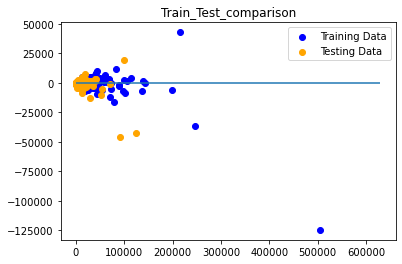

In [31]:
plt.scatter(regressor.predict(X_train), regressor.predict(X_train) - y_train, c="blue", label="Training Data")
plt.scatter(regressor.predict(X_test), regressor.predict(X_test) - y_test, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y.min(), xmax=y.max())
plt.title("Train_Test_comparison")
plt.show()

In [32]:
print(f'Actual:\t\t{list(y_test[:10])}')
print(f'Predicted:\t{list(regressor.predict(X_test[:10]))}')

Actual:		[369, 129, 2149, 1436, 678, 1009, 1069, 11366, 186, 844]
Predicted:	[321.3, 169.175, 2312.95, 1691.4, 536.85, 1324.975, 1185.825, 8725.425, 198.325, 776.525]


In [33]:
# correlation between college education and unemployement 
employment_county_copy['completed_college_county'].corr(employment_county_copy['unemployed'],method='pearson')

0.9328408811984836

In [34]:
# correlation between population education and unemployement 
employment_county_copy['population'].corr(employment_county_copy['unemployed'],method='pearson')

0.9742513547841045

In [35]:
# correlation between population education and unemployement 
employment_county_copy['Not_completed_college_county'].corr(employment_county_copy['unemployed'],method='pearson')

0.9557224475947075

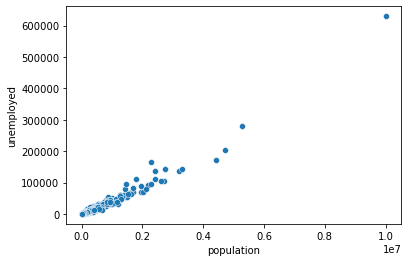

In [36]:
x=employment_county_copy['population']
y=employment_county_copy['unemployed']
sns.scatterplot(x="population", y="unemployed", data=employment_county_copy);

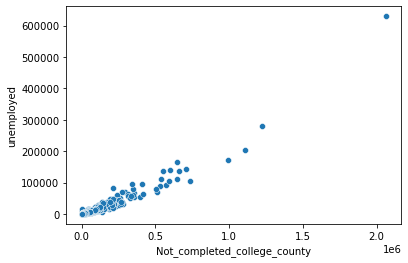

In [37]:
x=employment_county_copy['Not_completed_college_county']
y=employment_county_copy['unemployed']
sns.scatterplot(x="Not_completed_college_county", y="unemployed", data=employment_county_copy);

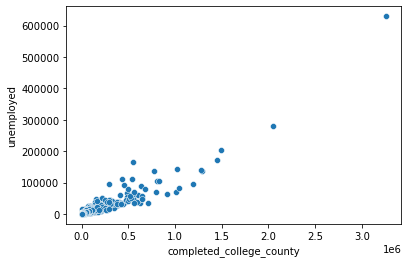

In [38]:
x=employment_county_copy['completed_college_county']
y=employment_county_copy['unemployed']
sns.scatterplot(x="completed_college_county", y="unemployed", data=employment_county_copy);